# 1. CASE 2. Classifier for detection of pneumonia using convolutional neural networks for inbalanced data

TEAM 10: 
Eliecer Diaz, Muskan Kaushik,and Zakaria Hasan

2. Background

The convolutional neural networkconcept,also calledconvnets(CNN), applied to computer vision is important,sinceit has to do with understanding on how we (as humans) recognize images, and how implement this understanding to automatize this knowledge.
Convolutional networks are a type of algorithm used to classify images, it is surprisingly simple, although the adjustments and effective architectures can become somehow complex. The idea behind is that the basic unit of input data comprises a 2D dimensional array, which can contain 1-3 or more colour channel, is passed to a sequence of filters or kernels which extract features in the image to make it classifiable.

3. Objectives
- To learn to use convnets (CNN) in order to create a binary classifier for x-ray chest images.
- To build, fit three different CNN models and compare performace, using an additional metric different from accuracy, eg. sensitivity or specificity.
- To select the best model and explain the decision.

4. Methods

a. Data was provided by Kermany et al. (2018)from Mandeley Data repository number two. Dataset contains Chest X-Ray Images, concerning diagnosis of pneumonia. The data was split into a proportion 60:20:20, corresponding to training, validation and testing data by the authors.

b. Data exploration and processing comprised:
 1. rescaling the each image, this was done using ImageGeneratorfunction
 2. resize the image, to obtain 150 by 150 pixels, again we used ImageGenerator function
 3. We shuffle images (not Test set) using Image generator functions.
 
 Here the steps:


# Loading libraries: 

In [1]:
import random 
import collections
random.seed(7)
import tensorflow as tf
from tensorflow.keras import layers,models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.metrics import SensitivityAtSpecificity
import matplotlib.pyplot as plt
from time import time
import tensorflow.keras.backend as k
import tensorflow.keras.callbacks as Callback
import matplotlib.pyplot as plot
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [2]:
# In case we have GPU e.g. Kaggle notebook we use it, otherwise we used CPU
device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found in this computer")
else:
    print("Found GPU at: {}".format(device_name))


GPU device not found in this computer


In [3]:
#The data was read from three directories: train, validation and test
train_dir = r'/home/elvi/Desktop/pneumonia2/train' #'/kaggle/input/pneumonia/pneumonia2/train'
val_dir = r'/home/elvi/Desktop/pneumonia2/validation'#'/kaggle/input/pneumonia/pneumonia2/validation'
test_dir = r'/home/elvi/Desktop/pneumonia2/test'#'/kaggle/input/pneumonia/pneumonia2/test'

In [4]:
os.listdir(train_dir)

['PNEUMONIA', 'NORMAL']

Examination of data balance, this implies to count how many photos 
corresponded to each category: 'PNEUOMONIA' or 'NORMAL', in each
directory.

In [5]:
folders = ['train', 'validation', 'test']
for i in folders:
    print(i)
    Pneu = os.listdir('/home/elvi/Desktop/pneumonia2/{}/PNEUMONIA'.format(i)) # dir is your directory path
    Norm = os.listdir('/home/elvi/Desktop/pneumonia2/{}/NORMAL'.format(i)) 
    print(len(Pneu), len(Norm), ", % of sick / total =", 100*(len(Pneu)/(len(Pneu) + len(Norm))))

train
2564 949 , % of sick / total = 72.98605180757187
validation
855 317 , % of sick / total = 72.95221843003414
test
854 317 , % of sick / total = 72.92912040990606


It is possible oberve an inbalance between patients presenting Pneumonia and not.
This inbalance corresponded to a 73%. This implies that if we pick randomly a 
patient from the dataset, there is 73% of chance that presents Pneumonia.
This create a benchmark, which needs to be improved by our classifier.

This is the data generator function which helps to process the data, e.g.
rescale, resize images.

In [6]:
val_datagen = ImageDataGenerator(rescale=1./255)
test_generator = val_datagen.flow_from_directory(
        test_dir,
        #verbose = 0,
        shuffle=False,
        target_size = (150, 150),
        batch_size = 1, #<----tensorflow documentation
        class_mode='binary')

Found 1171 images belonging to 2 classes.


# CREATING MODELS

Model creation: Three models comprising similar architechture were constructed to test 
the effect of the batch_size. The batch_sizes used were 16, 32 and 64.
Model was compiled using binary_crossentropy as loss function, the optimizer rmsprop was used
with a learning rate of 0.0001.
Different metrics were used for evaluation:
    1. ”Accuracy”
    2. ”Recall” 
    3. ”Precision”. 

In [7]:
# Here the architechture that will vary according the batch size as was requested in class
def model_(neurones, batch): 
    
    #getting DIFFERENT metrics from Accuracy 
    Preci = tf.keras.metrics.Precision() 
    Recal = tf.keras.metrics.Recall() 
    
    #Image generator to rescale images
    train_datagen = ImageDataGenerator(rescale=1./255) # here we could use more features for augmentation
    #it was not necessary
    
    val_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size = (150, 150),
        batch_size = batch,
        class_mode = 'binary')
    
    val_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size = (150, 150),
        batch_size = batch,
        class_mode='binary')
    
    try:
        with tf.device('/device:GPU:0'): #In case we have GPU use it:
        
            model = tf.keras.models.Sequential()
            model.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)))
            model.add(MaxPooling2D((2, 2)))
            model.add(Conv2D(64, (3, 3), activation = 'relu'))
            model.add(MaxPooling2D((2, 2)))
            model.add(Conv2D(32, (3, 3), activation = 'relu'))
            model.add(MaxPooling2D((2, 2)))
            model.add(Conv2D(16, (3, 3), activation = 'relu'))
            model.add(MaxPooling2D((2, 2)))
            model.add(tf.keras.layers.Flatten())
            model.add(Dense(neurones, activation = 'relu'))
            model.add(Dense(1, activation = 'sigmoid'))

            model.compile(loss = 'binary_crossentropy',
                          optimizer = tf.keras.optimizers.RMSprop(lr = 1e-4),
                          metrics = ['acc', Preci, Recal])
            print("GPU/TPU IS ON")
    except: #when we dont have a GPU:
        
            model = tf.keras.models.Sequential()
            model.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)))
            model.add(MaxPooling2D((2, 2)))
            model.add(Conv2D(64, (3, 3), activation = 'relu'))
            model.add(MaxPooling2D((2, 2)))
            model.add(Conv2D(32, (3, 3), activation = 'relu'))
            model.add(MaxPooling2D((2, 2)))
            model.add(Conv2D(16, (3, 3), activation = 'relu'))
            model.add(MaxPooling2D((2, 2)))
            model.add(tf.keras.layers.Flatten())
            model.add(Dense(neurones, activation = 'relu'))
            model.add(Dense(1, activation = 'sigmoid'))

            model.compile(loss = 'binary_crossentropy',
                          optimizer = tf.keras.optimizers.RMSprop(lr = 1e-4),
                          metrics = ['acc', Preci, Recal])
            print("NOT USING GPU")

    return model, train_generator, val_generator

In [8]:
%%capture
# Here some hyperparameters that were modified:

neurones = [216] # neurones in the dense layer
batches = [8, 32, 64] # for batch size evaluation requested by S. Lukkarinen

# create dictionaries to store data: e.g. Models{ model_8, model_32, and model_64}
models = {}
train_generators = {}
val_generators = {}

for ss in neurones: #in the end we use 1 value for neurones, we could have used more with a better GPU
    for batch in batches:
        model_ss_batch = 'models_{}_{}'.format(ss, batch)  # creating the keys
        models[model_ss_batch] = model_(ss, batch) # appending the model to the key
        
        train_generator_ss_batch = 'train_generators_{}_{}'.format(ss, batch)  # creating the keys
        train_generators[train_generator_ss_batch] = model_(ss, batch) # appending the generator to the key
        
        val_generator_ss_batch = 'val_generators_{}_{}'.format(ss, batch)  # creating the keys
        val_generators[val_generator_ss_batch] = model_(ss, batch) # appending the model to the key       
        

In [9]:
# Only to check the correct appending in the dictionary 
print(models.keys()) #prints keys
print(train_generators.keys()) #prints keys
print(val_generators.keys()) #prints keys


dict_keys(['models_216_8', 'models_216_32', 'models_216_64'])
dict_keys(['train_generators_216_8', 'train_generators_216_32', 'train_generators_216_64'])
dict_keys(['val_generators_216_8', 'val_generators_216_32', 'val_generators_216_64'])


# **Model Fitting**


In [10]:
Final_models = {} # create a dictionary of FITTED models
for i in range(len(models)):
    print('MODEL:',i)
    Final_model_i = 'models_{}'.format(i)  # creating the keys
    
    # and here the fitting, but it append it to the dictionary
    Final_models[Final_model_i] = models[list(models.keys())[i]][0].fit_generator(
        train_generators[list(train_generators.keys())[i]][1],
        steps_per_epoch = None, 
        verbose = 0,
        epochs = 20, # we used 20 since the process was very very slow..and metrics tend to stabilize at 10 epochs
        validation_data = val_generators[list(val_generators.keys())[i]][1],
        validation_steps = None, 
    )
    # saving the model
    models[list(models.keys())[i]][0].save("model{}.h5".format(i))

MODEL: 0
MODEL: 1
MODEL: 2


# RESULTS

In [20]:
class EVALUATE:
    
    def fitting_evaluation():

        for i in range(len(Final_models)):
            print(i)
            models_key = Final_models.keys()
            model_key = [j  for  j in  models_key]
            metrics = Final_models[list(Final_models.keys())[i]].history.keys()
            metric = [k  for  k in  metrics]

            acc = Final_models[list(Final_models.keys())[i]].history[metric[1]]
            val_acc = Final_models[list(Final_models.keys())[i]].history[metric[5]]

            preci = Final_models[list(Final_models.keys())[i]].history[metric[2]]
            val_preci = Final_models[list(Final_models.keys())[i]].history[metric[6]]

            recal = Final_models[list(Final_models.keys())[i]].history[metric[3]]
            val_recal = Final_models[list(Final_models.keys())[i]].history[metric[7]]

            loss = Final_models[list(Final_models.keys())[i]].history[metric[0]]
            val_loss = Final_models[list(Final_models.keys())[i]].history[metric[4]]

            epochs = range(len(acc))

            fig, axs = plt.subplots(1, 4, figsize=(10, 9))


            axs[ 0].set_title('1. Accuracy')
            axs[ 0].plot(epochs, acc, 'bo-', label = 'Training acc')
            axs[ 0].plot(epochs, val_acc, 'r*-', label = 'Validation acc')

            axs[ 1].set_title('2. Precision ')
            axs[ 1].plot(epochs, preci, 'bo-', label = 'Precision_training ')
            axs[ 1].plot(epochs, val_preci, 'r*-', label = 'Precision validation')

            axs[ 2].set_title('3. Recall (sensitivity) ')
            axs[ 2].plot(epochs, recal, 'bo-', label = 'Recall training')
            axs[ 2].plot(epochs, val_recal, 'r*-', label = 'Recall validation')

            axs[ 3].set_title('4. Loss')
            axs[ 3].plot(epochs, loss, 'bo-', label = 'Training loss')
            axs[ 3].plot(epochs, val_loss, 'r*-', label = 'Validation loss')


            fig.suptitle(model_key[i], fontname="Times New Roman",fontweight="bold")
            fig.text(0.5, 0.04, 'EPOCH', ha='center', fontname="Times New Roman",fontweight="bold")
            plt.show()
    

    def metric_evaluation():
        test_generator.reset() # resetting generator
        for i in range(0, len(Final_models)):
            Loss, Accuracy, Preci, Recal = models[list(models.keys())[i]][0].evaluate_generator(generator=test_generator)
            print("Model", i)
            print('Loss: {}'.format(Loss), 'Accuracy: {}'.format(Accuracy), 'Precision: {}'.format(Preci), 'Recall: {}'.format(Recal))

    
    
    def confusion_threshold_evaluation(cutoff): 

        Y_labels = test_generator.classes

        for i in range(0, len(Final_models)):
            print("Prediction for model {}:".format(i))

            Y_pred = models[list(models.keys())[i]][0].predict_generator(test_generator)
            Y_pred = 1*(Y_pred.astype('float64') > cutoff)

            print('Confusion Matrix')
            print(confusion_matrix(Y_labels, Y_pred))
            print('Classification Report')
            target_names = ['1','0']
            print(classification_report(Y_labels, Y_pred, target_names=target_names))

            logit_roc_auc = roc_auc_score(Y_labels, Y_pred)

            fpr, tpr, thresholds = roc_curve(Y_labels, Y_pred)


            fig, axs = plt.subplots(1, 2, figsize=(10, 10))

            axs[0].set_title('1. ROC')
            axs[0].plot(fpr, tpr, label='MODEL 1 (area = %0.2f)' % logit_roc_auc)
            axs[0].plot([0, 1], [0, 1],'r--')
            axs[0].set_xlabel('False Positive Rate')
            axs[0].set_ylabel('True Positive Rate')
            axs[0].legend(loc="lower right")

            axs[1].set_title('2. Threshold analysis ')
            axs[1].plot(thresholds, 1- fpr, label = 'Specificity')
            axs[1].plot(thresholds, tpr, 'r*-', label = 'Sensitivity')
            axs[1].set_xlabel('Threshold')
            axs[1].set_ylabel('Metrics value')

            plt.show()        
        

0


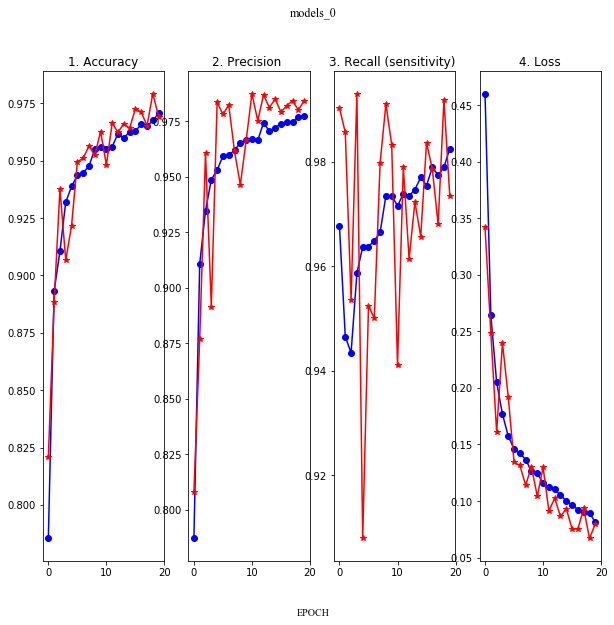

1


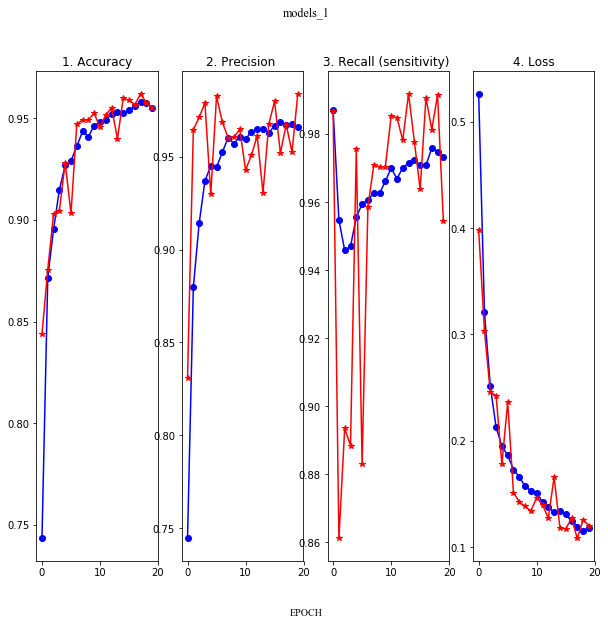

2


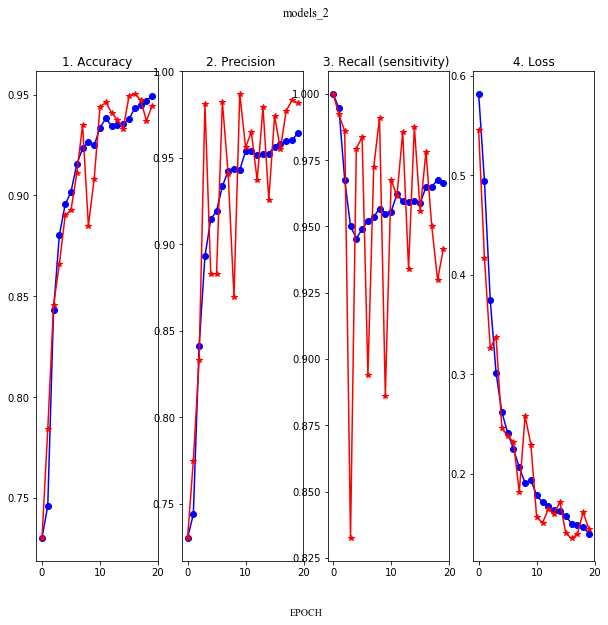

In [13]:
trail_1 = EVALUATE.metric_evaluation()
#trail_2 = EVALUATE.valuation_graphs(0.6)
trail_0 = EVALUATE.fitting_evaluation()

In [14]:
trail_1 = EVALUATE.metric_evaluation()

Model 0
Loss: 0.10937583655189508 Accuracy: 0.9649872183799744 Precision: 0.977673351764679 Recall: 0.9742388725280762
Model 1
Loss: 0.1291739613041655 Accuracy: 0.9521776437759399 Precision: 0.9807229042053223 Recall: 0.9531615972518921
Model 2
Loss: 0.13091884174218377 Accuracy: 0.9598633646965027 Precision: 0.9855595827102661 Recall: 0.9590163826942444


In [ ]:
#Additionally as Lukkarinen (2012), suggested
#in his PhD thesis, at certain specific threshold(cutoff), when sensitivity(recall) and specificity curves cross
#with each other, that is the best result that the model can achieve. 

#In order to organize these criteria:
#we created three fucntions within a class EVALUATE. We are not python developers, so excuse us
#all coding sacrileges.
#sensitivity at specificity? sensitivity 
Y_labels = Y_labels.reshape(1171,)
m = tf.keras.metrics.SensitivityAtSpecificity(0.9, num_thresholds = 1)
m.update_state(Y_labels, Y_pred)
m.result().numpy()

Prediction for model 0:
Confusion Matrix
[[298  19]
 [ 22 832]]
Classification Report
              precision    recall  f1-score   support

           1       0.93      0.94      0.94       317
           0       0.98      0.97      0.98       854

   micro avg       0.96      0.96      0.96      1171
   macro avg       0.95      0.96      0.96      1171
weighted avg       0.97      0.96      0.97      1171



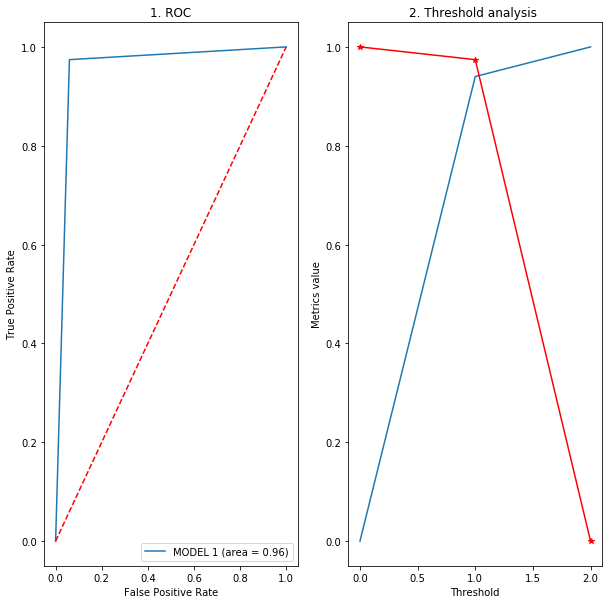

Prediction for model 1:
Confusion Matrix
[[301  16]
 [ 40 814]]
Classification Report
              precision    recall  f1-score   support

           1       0.88      0.95      0.91       317
           0       0.98      0.95      0.97       854

   micro avg       0.95      0.95      0.95      1171
   macro avg       0.93      0.95      0.94      1171
weighted avg       0.95      0.95      0.95      1171



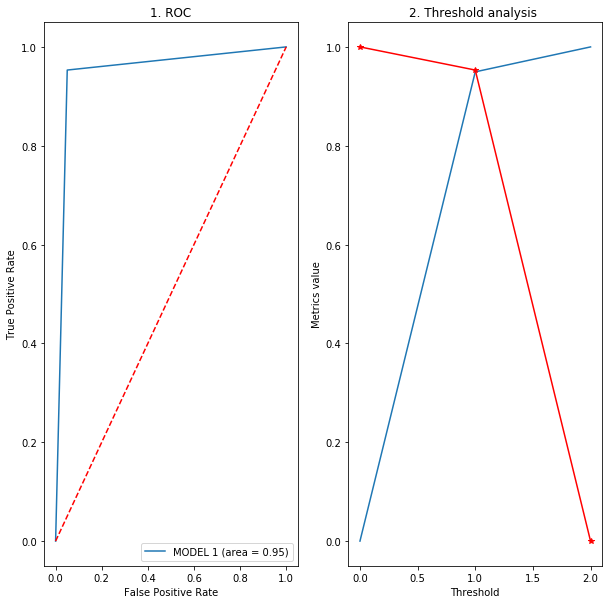

Prediction for model 2:
Confusion Matrix
[[305  12]
 [ 35 819]]
Classification Report
              precision    recall  f1-score   support

           1       0.90      0.96      0.93       317
           0       0.99      0.96      0.97       854

   micro avg       0.96      0.96      0.96      1171
   macro avg       0.94      0.96      0.95      1171
weighted avg       0.96      0.96      0.96      1171



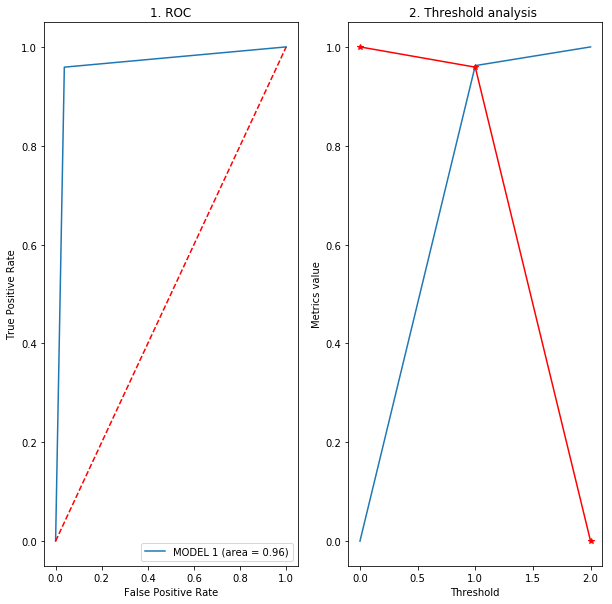

In [25]:
cutoff = 0.5
EVALUATE.confusion_threshold_evaluation(cutoff)